# DAT 402 Project 1

#### I. Dataset Acquisition and Goal Definition
    Load and clean the dataset, define the goal.

#### II. Exploratory Data Analysis (EDA)
    Perform exploratory data analysis, visualize distributions and correlations.

#### III. Data Splitting
    Split data into training and testing sets.

#### IV. Feature Engineering
    Apply feature engineering techniques.
    
#### V. Data Rescaling
    Rescale the data for modeling.
    
#### VI. Model Training and Hyperparameter Tuning
    Train and tune multiple models.

#### VII. Model Evaluation on Test Data
    Evaluate model on test data and measure performance.
    
#### VIII. Discussion of Results
    Summarize and discuss the results.


### I. Dataset Acquisition and Goal Definition

In [1]:
# Importing necassary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn import metrics
import mplfinance as mpf
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import CategoricalNB
import numpy as np

### I. Dataset Acquisition and Goal Definition

#### Dataset Name: "Nvidia Daily Stock Price Data"
#### Data Source: [Kaggle](https://www.kaggle.com/datasets/jvanark/nvidia-daily-stock-price-data?resource=download)
#### Target Variable: 'Close' (closing stock price)

The data set includes daily stock prices for Nvidia Corporation-NVDA-from January 2, 2004, through to January 1, 2024, totaling more than 5,000 observations. Each entry provides essential financial information about opening, high, low, and closing prices, supplemented by trading volume. This dataset is representative of the most important market trends that Nvidia has undergone during its rise to fame in the technology world. Our task will be the forecasting of the stock price of Nvidia for January 1, 2026.

For this, we have to preprocess the data by cleaning it for machine learning models: fill in the missing values, convert the dates into formats that might be useful, prepare the features of stock prices in advance for a predictive analysis. We are going to split the data afterwards into training and test sets to evaluate the model performance.

#### The dataset contains the following 6 features:
- **Date**: The trading date.
- **Open**: The stock price at the beginning of the trading day.
- **High**: The highest price of Nvidia stock on the given day.
- **Low**: The lowest price of Nvidia stock on the given day.
- **Close**: The stock price at the end of the trading day (our target variable).
- **Volume**: The total number of shares traded on that day.

In [5]:
# Load the NVIDIA stock prices data from a CSV file
nvidia_data = pd.read_csv('nvidia_stock_prices.csv')

# Make sure the 'Date' column is actually treated as dates (instead of strings or something weird)
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])

# Set 'Date' as the index so we can easily work with it as a time series (makes life easier later)
nvidia_data.set_index('Date', inplace=True)

# We're interested in predicting the 'Close' price, which is the target variable (what we care about)
target = ['Close']

# Quick check: print out the first few rows of the dataset to see what it looks like
print("First 5 rows of the dataset:")
display(nvidia_data.head(5))

# Print the shape (rows, columns) of the dataset just to get an idea of its size
print("Dataset shape:", nvidia_data.shape)

# Check for any missing values in the dataset—always good to know if there are holes in your data
missing_values = nvidia_data.isnull().sum()
print("\nMissing values in the dataset:\n", missing_values)

# Just making sure there are more than 500 data points to work with (otherwise, not enough data)
assert len(nvidia_data) > 500, "The dataset contains fewer than 500 observations."

# If there are any missing values, just drop those rows to clean up the data
nvidia_cleaned = nvidia_data.dropna()

# Show some info about the cleaned dataset, like number of entries, data types, etc.
print("\nCleaned Dataset Overview:")
nvidia_cleaned.info()

First 5 rows of the dataset:


,Open,High,Low,Close,Volume
Date,,,,,
2004-01-02,0.196417,0.199083,0.192333,0.192333,436416000
2004-01-05,0.195250,0.199917,0.193500,0.198583,575292000
2004-01-06,0.198000,0.209417,0.197083,0.206667,1093344000
2004-01-07,0.204333,0.209500,0.202917,0.208500,673032000
2004-01-08,0.211083,0.212083,0.207250,0.209250,433752000


Dataset shape: (5033, 5)

Missing values in the dataset:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Cleaned Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2004-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5033 non-null   float64
 1   High    5033 non-null   float64
 2   Low     5033 non-null   float64
 3   Close   5033 non-null   float64
 4   Volume  5033 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 235.9 KB


### II. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

We begin by calculating the descriptive statistics of the dataset, which includes basic metrics such as mean, standard deviation, minimum, and maximum values for each feature: `Open`, `High`, `Low`, `Close`, and `Volume`. These statistics provide an initial understanding of the central tendency and dispersion in the dataset.

- **Mean**: The average value for each feature, indicating the central value around which the data points are distributed.
- **Standard Deviation**: Shows how much variation exists from the mean.
- **Min/Max**: These values help identify the range of stock prices and volumes in the dataset, giving a sense of the dataset's spread.

This summary highlights that Nvidia's stock prices and trading volumes have varied significantly over the 20-year period, particularly in recent years, where exponential growth in stock price is evident.

In [6]:
# Descriptive statistics
print("\nDescriptive statistics of the dataset:")
display(nvidia_cleaned.describe())


Descriptive statistics of the dataset:


,Open,High,Low,Close,Volume
count,5033.000000,5033.000000,5033.000000,5033.000000,5.033000e+03
mean,5.214671,5.308604,5.117086,5.217039,5.587962e+08
std,9.643976,9.811276,9.465058,9.644928,3.363408e+08
min,0.080583,0.083917,0.077500,0.078583,4.564400e+07
25%,0.344000,0.349000,0.336500,0.343250,3.482920e+08
50%,0.544000,0.552750,0.532500,0.542000,4.910920e+08
75%,5.233750,5.296500,5.125000,5.229000,6.816760e+08
max,50.216000,50.548000,49.411999,50.409000,5.088948e+09


##### Histograms for Feature Distributions

We further explore the distributions of key features (`Open`, `High`, `Low`, `Close`, and `Volume`) using histograms. The histograms reveal the frequency distribution of stock prices and trading volumes:

- **Stock Prices**: All price-related features (`Open`, `High`, `Low`, `Close`) exhibit a right-skewed distribution, indicating that Nvidia's stock price has predominantly stayed at lower levels for the majority of the dataset's time range but saw significant increases toward the upper end.
- **Volume**: Trading volumes also show a right-skewed pattern, indicating that most trading days experienced relatively low volumes, with some days showing exceptionally high volumes.

The distributions align with Nvidia's historical trajectory, where rapid growth occurred mostly in recent years.


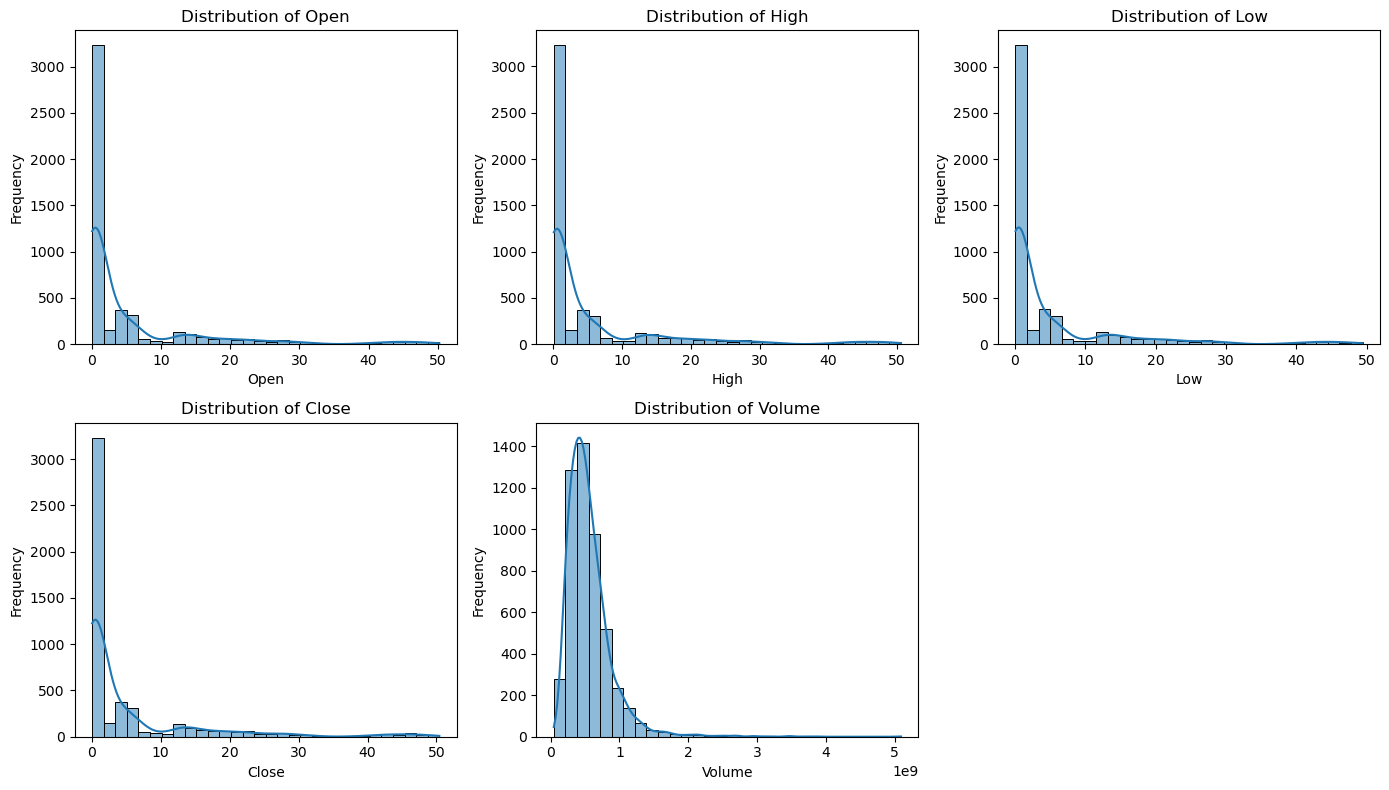

In [7]:
# Plotting histograms for stock price features
plt.figure(figsize=(14, 8))

# Histograms for data variables
features = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(nvidia_cleaned[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Scatter Plots of Input Features vs. Close Price

Scatter plots are used to analyze the relationships between input features (`Open`, `High`, `Low`, and `Volume`) and the `Close` price:

- **Price Features (`Open`, `High`, `Low`)**: All three of these price features are strongly linearly related with the `Close` price, which suggests the open, high, and low prices will be strong predictors of the close price for any given day. This is what one would expect since stock prices tend to vary within a consistent range on any single trading day.
- **Volume vs. Close**: The relationship is less linear between `Volume` and `Close`, but from the scatter plot, it seems that days when volumes are higher tend to reflect also a wider spread in the closing price. This may indicate that days with high trading volume coincide with big increases and big decreases in price; therefore, volatility.


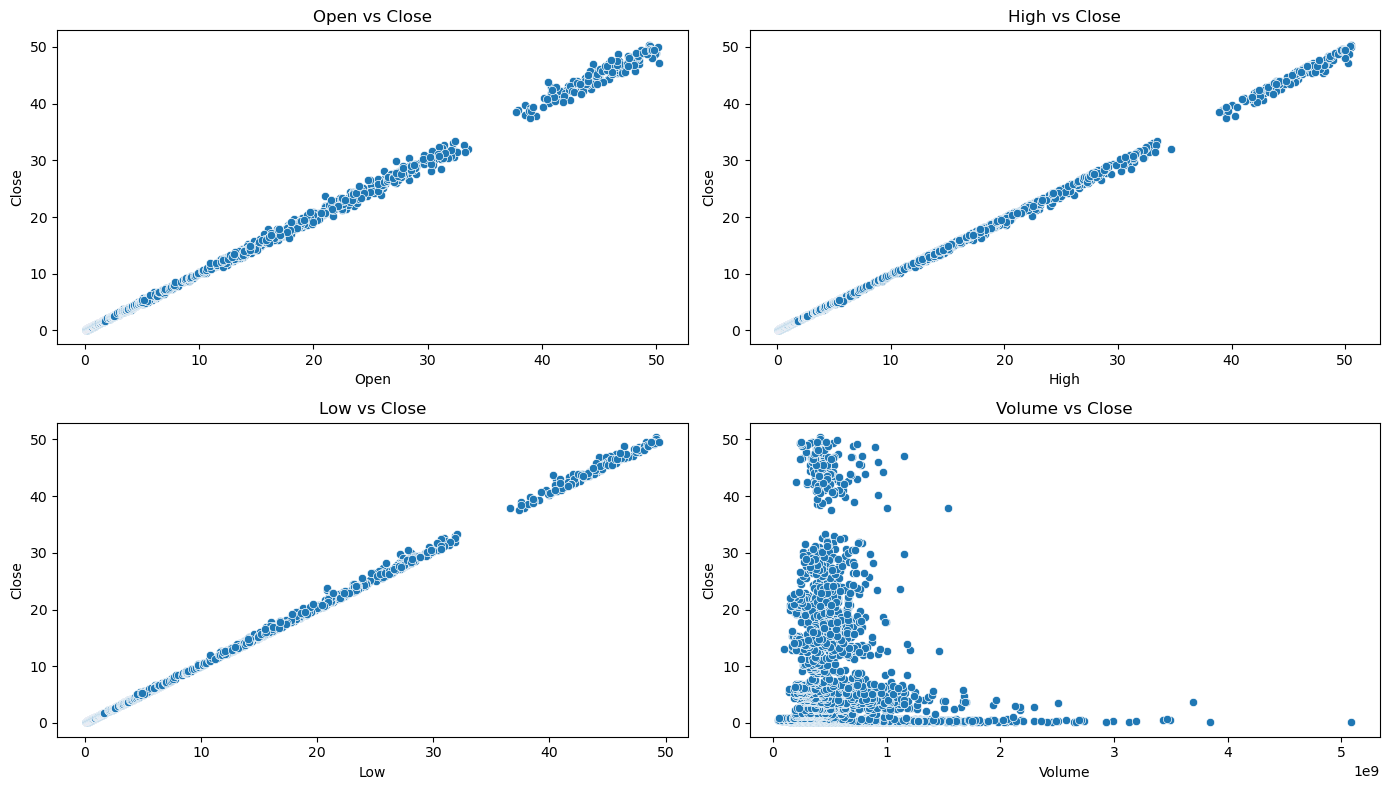

In [8]:
# Scatter plots to explore the relationships between input features and 'Close' (target)
plt.figure(figsize=(14, 8))

for i, feature in enumerate(['Open', 'High', 'Low', 'Volume']):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=nvidia_cleaned[feature], y=nvidia_cleaned['Close'])
    plt.title(f'{feature} vs Close')
    plt.xlabel(f'{feature}')
    plt.ylabel('Close')

plt.tight_layout()
plt.show()

##### Time-Series Line Plots for Close Price and Volume Over Time

To capture the long-term trends in Nvidia's stock price and trading activity, we plot the `Close` price and `Volume` traded over time:

- **Close Price Over Time**: The following chart is an indication of how Nvidia has grown from relatively low stock prices in the early 2000s to exponential growth, starting from around 2016 into a sharp upturn these last couple of years. This has been simultaneous with developments by Nvidia in AI, GPU, and Gaming technologies.
- **Volume Traded Over Time**: This volume of trading tends to get spikier and spikier as time goes on. The volume of shares traded out does, however, remain at a minimum level compared to the higher growth witnessed in the `Close` price.

These time series plots confirm the huge growth that Nvidia has experienced within the last years, be it stock value or trading interest.


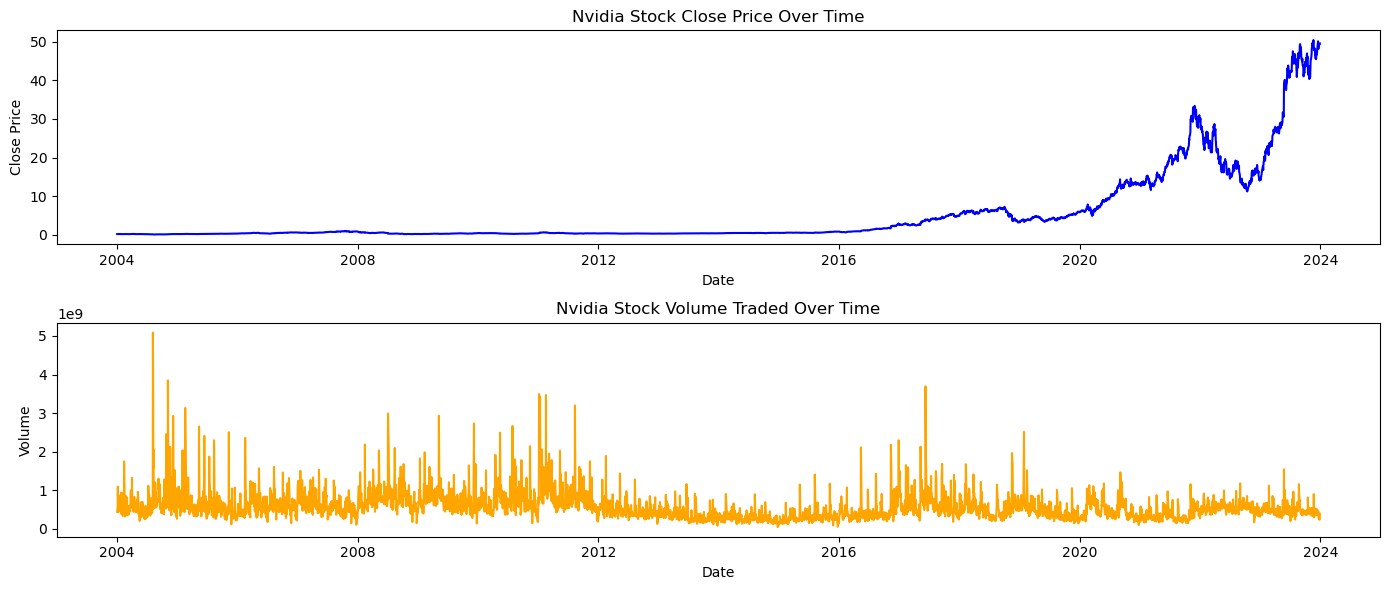

In [9]:
# Time-series line plot to visualize the trend of 'Close' and 'Volume' over time
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(nvidia_cleaned.index, nvidia_cleaned['Close'], label='Close Price', color='blue')
plt.title('Nvidia Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.subplot(2, 1, 2)
plt.plot(nvidia_cleaned.index, nvidia_cleaned['Volume'], label='Volume Traded', color='orange')
plt.title('Nvidia Stock Volume Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.tight_layout()
plt.show()

##### Pair Plot for Key Features

The pair plot allows us to see the relationships between all the important features, `Open`, `High`, `Low`, `Close`, `Volume` all on one graph. Each plot in the matrix shows a pairwise relationship of any two given features by indicating how each feature is related to the others:

- **Price Features**: A pair plot will highlight strong positive linear relationships among `Open`, `High`, `Low`, and `Close`, confirming our earlier observations from the scatter plots.
- **Volume**: If `Volume` looks related to any of the price features, which would indicate a weaker relation, knowing this would provide important context to understand the trading pattern on high-volume days.


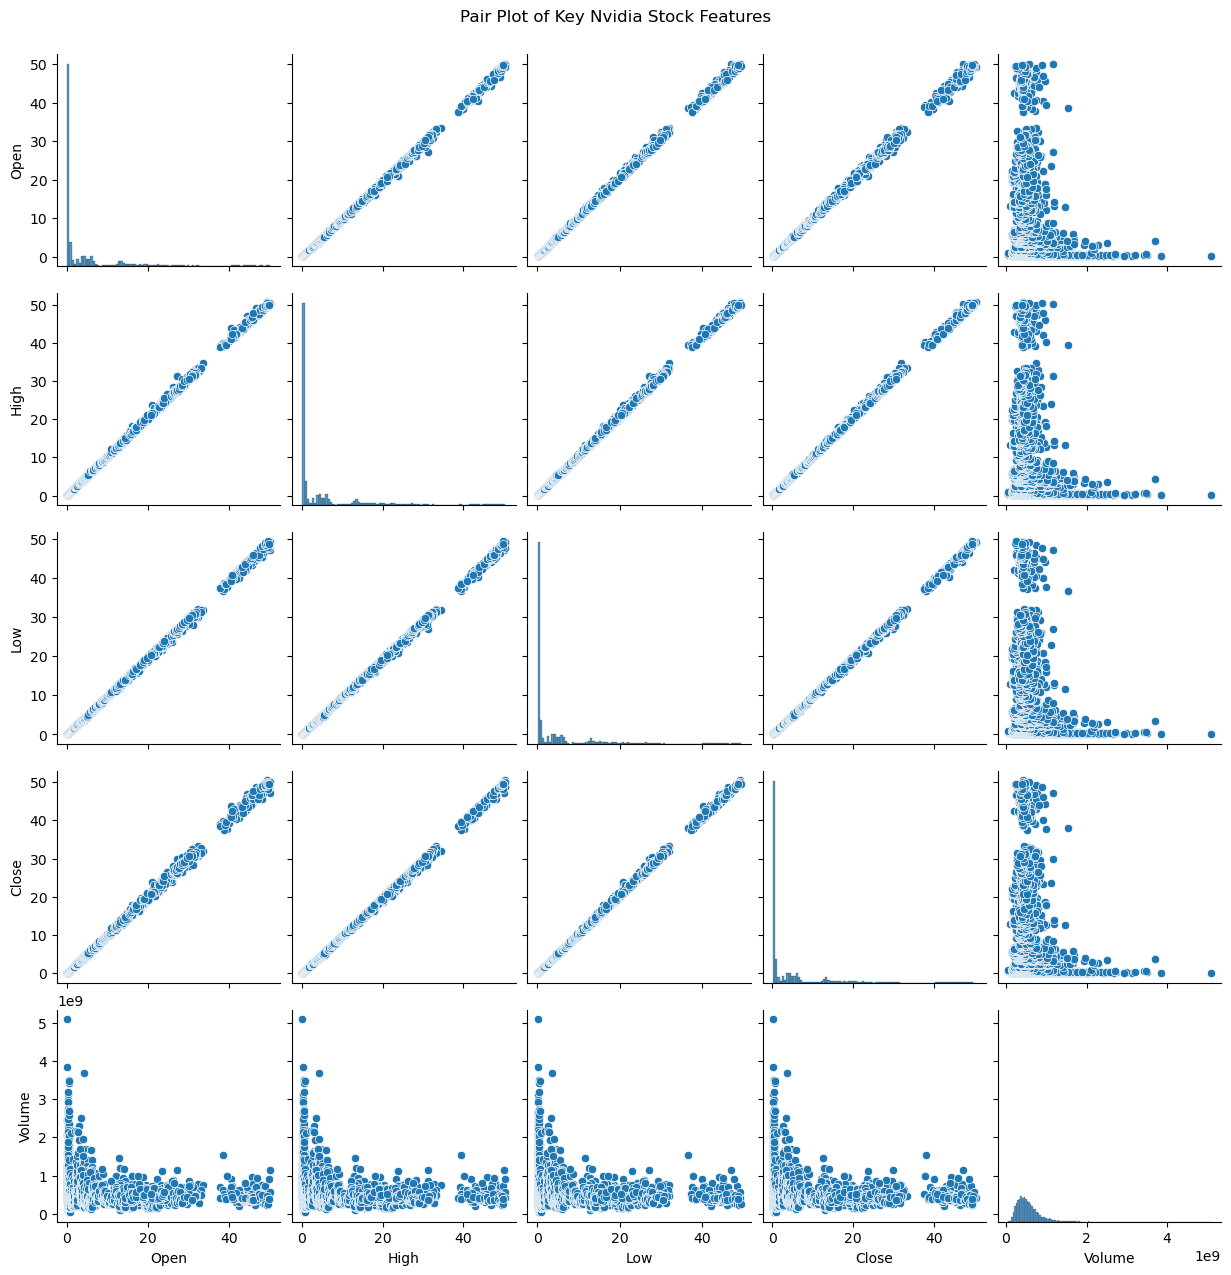

In [10]:
# Pair plot to visualize relationships between 'Open', 'High', 'Low', 'Close', and 'Volume'
sns.pairplot(nvidia_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.suptitle('Pair Plot of Key Nvidia Stock Features', y=1.02)
plt.show()

##### Candlestick Charts for 3-Year Intervals

To get a closer look at stock price trends and trading activity over time, candlestick charts are plotted for 3-year intervals from 2004 to 2024. These charts provide detailed visualizations of daily price movements (`Open`, `High`, `Low`, `Close`) and trading volumes:

- **2004-2006**: Nvidia stock experienced moderate growth, with consistent price increases.
- **2007-2009**: A period marked by volatility, possibly influenced by the 2008 financial crisis.
- **2010-2012**: A rebound in stock prices and gradual growth.
- **2013-2015**: Nvidia's stock begins to gain more traction as demand for GPUs and AI technologies starts to grow.
- **2016-2018**: The beginning of exponential growth, with significant price rises.
- **2019-2021**: Accelerated growth as Nvidia solidifies its position in AI and autonomous technologies.
- **2022-2024**: Recent data shows continued high stock prices, with increased volatility.

These candlestick charts offer an intuitive view of price trends and fluctuations, allowing for better understanding of Nvidia's market behavior over the past two decades.


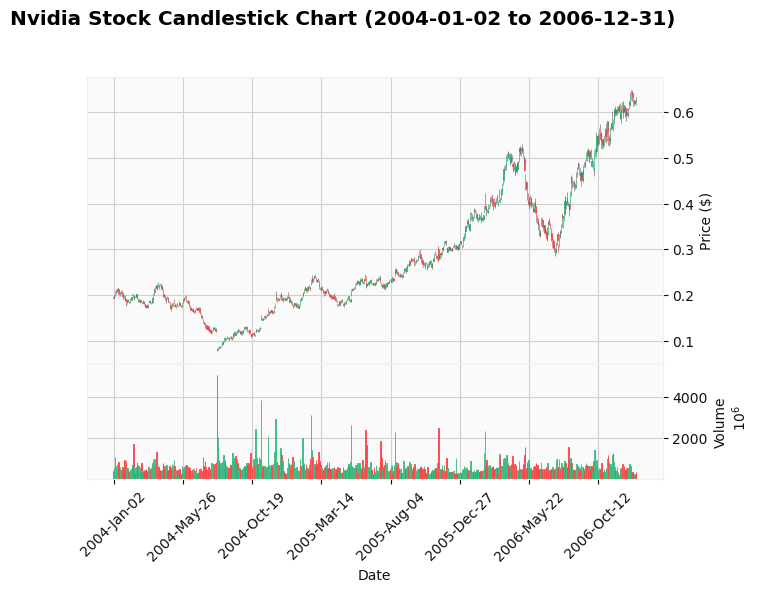

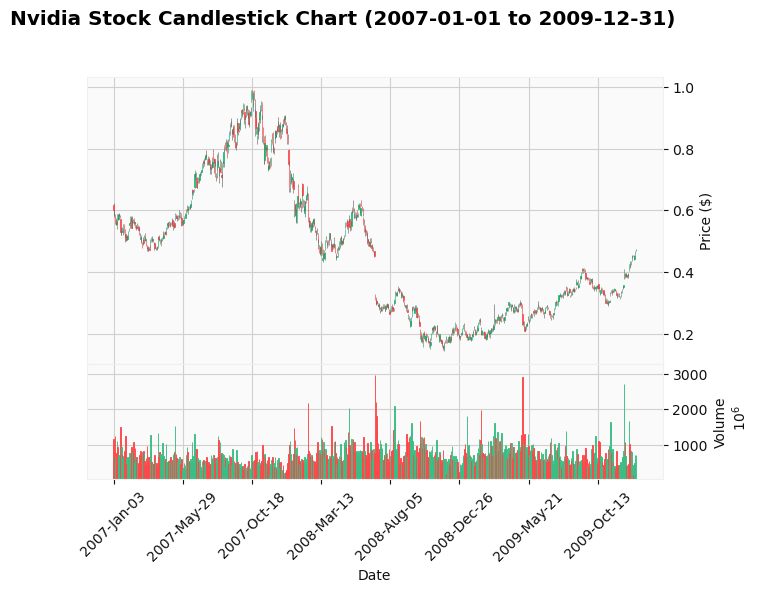

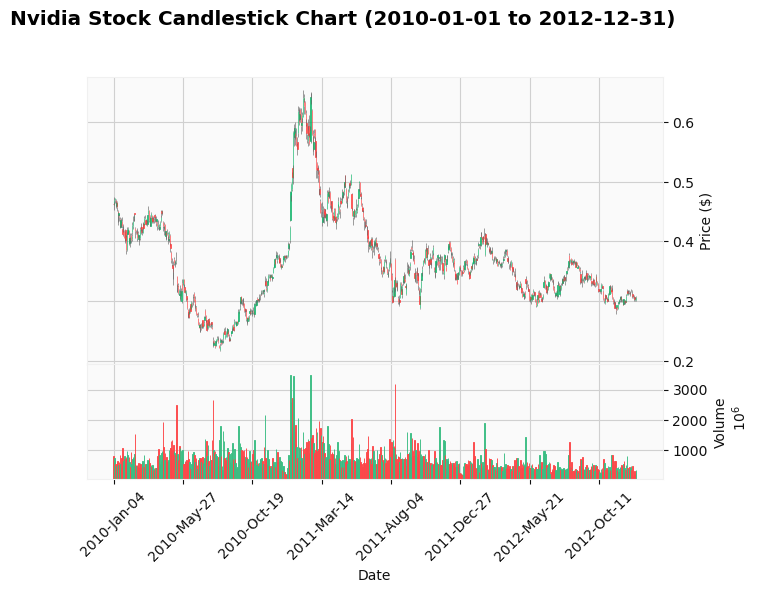

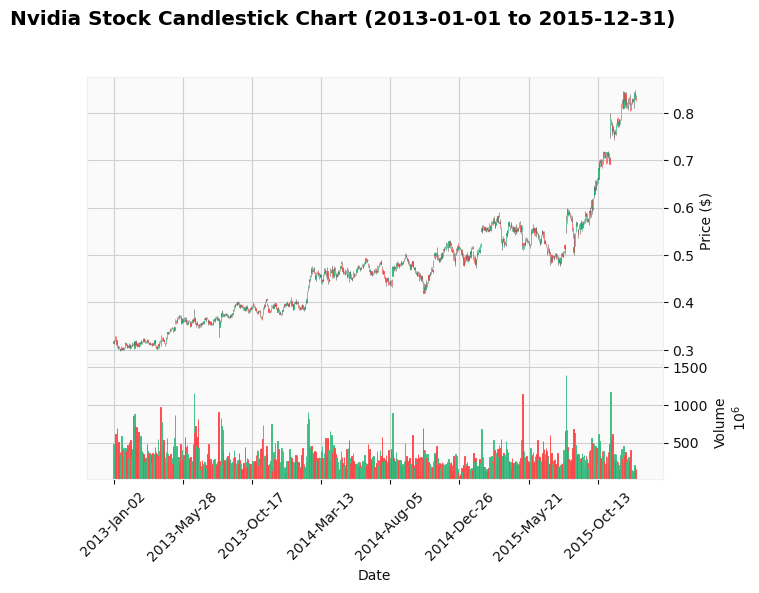

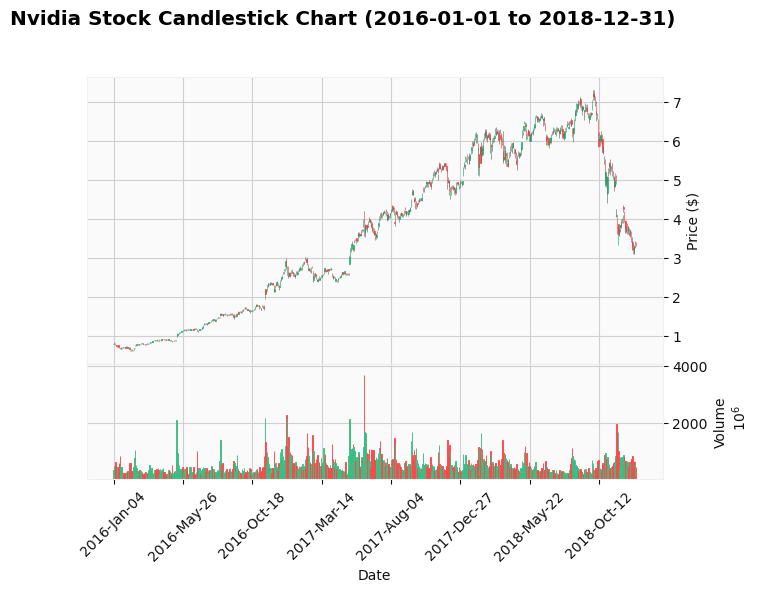

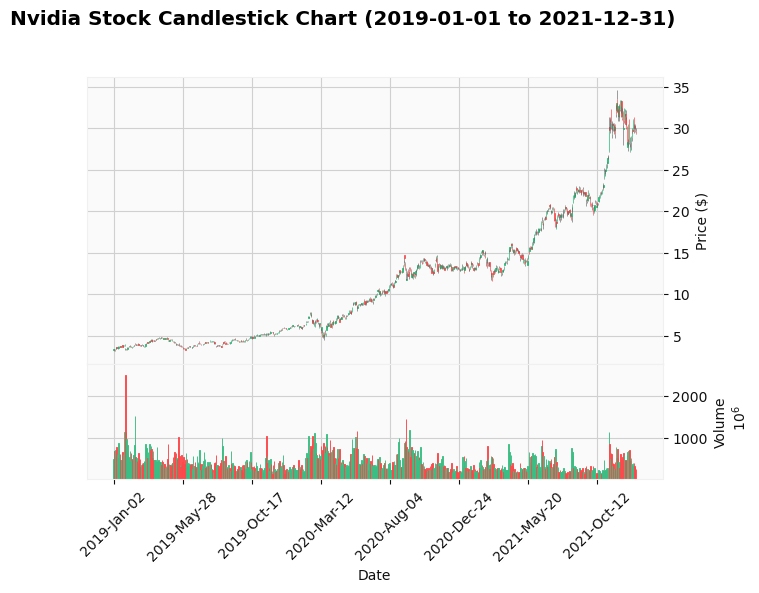

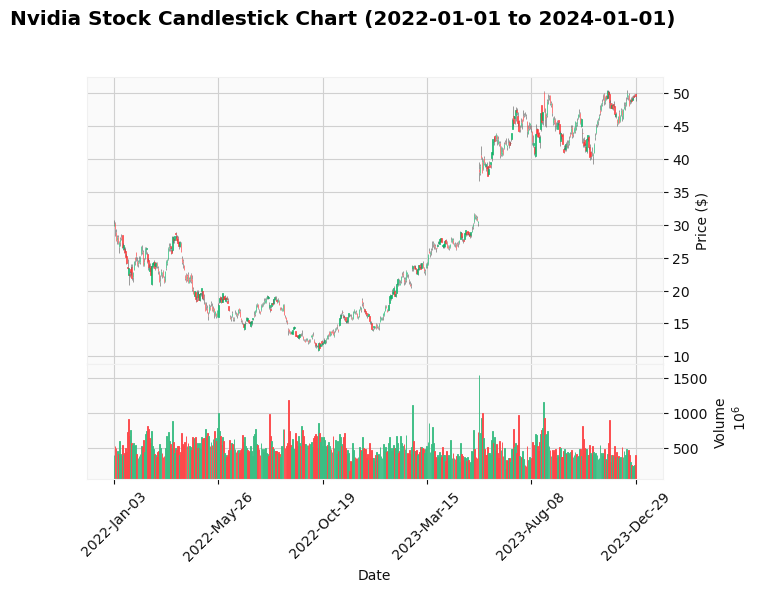

In [11]:
# Define a bunch of 3-year date ranges we want to analyze
date_ranges = [
    ('2004-01-02', '2006-12-31'),
    ('2007-01-01', '2009-12-31'),
    ('2010-01-01', '2012-12-31'),
    ('2013-01-01', '2015-12-31'),
    ('2016-01-01', '2018-12-31'),
    ('2019-01-01', '2021-12-31'),
    ('2022-01-01', '2024-01-01')
]

# Loop through each of those 3-year periods and make some candlestick charts
for start_date, end_date in date_ranges:
    # Filter the data to only include rows within the current 3-year range
    nvidia_3_years = nvidia_cleaned.loc[start_date:end_date]
    
    # Plot a candlestick chart for each 3-year chunk. 
    # Note: we're suppressing warnings about too much data because we don’t care about them.
    mpf.plot(nvidia_3_years, type='candle', volume=True, 
             title=f"Nvidia Stock Candlestick Chart ({start_date} to {end_date})",
             ylabel='Price ($)', ylabel_lower='Volume', xlabel='Date', 
             style='yahoo', warn_too_much_data=1000000)


##### Percentage Change in Nvidia Stock Price

We calculate and plot the **percentage change** in Nvidia's stock price over time. This visualization helps capture daily fluctuations and volatility in the stock price:

- **Key Insights**: 
  - Serious volatility in times of fiscal crisis and rapid growth of technology in stock prices of Nvidia.
  - Major percent change spikes occur in 2008-the financial crisis-and post-2016, matching up pretty well with Nvidia's recent rising role in AI and GPU technologies.
  - The period starting from 2020 on has the highest values of significant gain and loss, therefore demonstrating the impact of market factors like the COVID-19 pandemic and increasing market share by Nvidia.

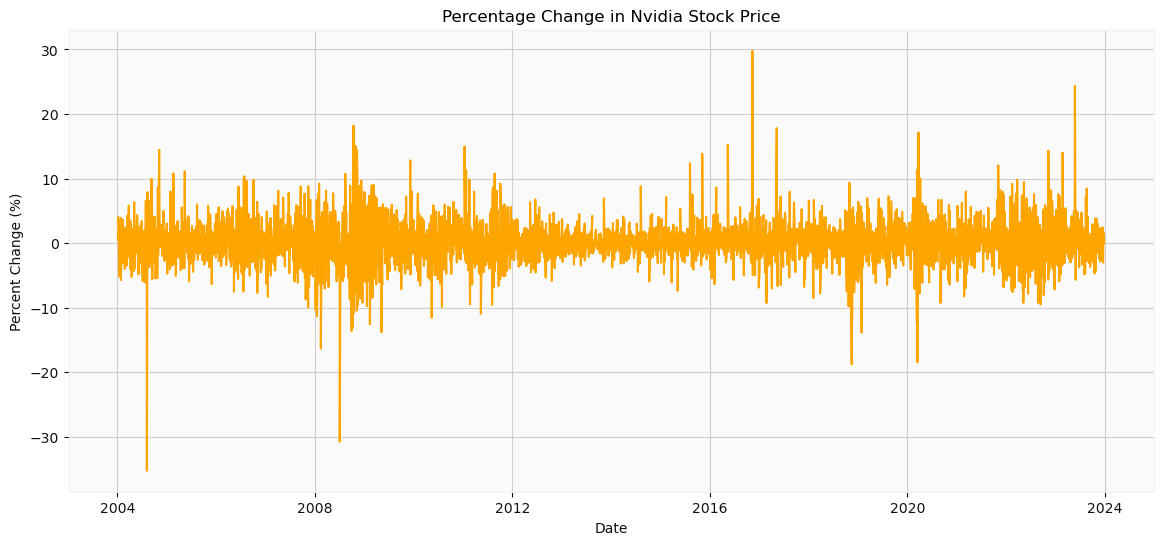

In [12]:
# Calculate percentage change
nvidia_cleaned['Percent_Change'] = nvidia_cleaned['Close'].pct_change() * 100

# Plot Percentage Change
plt.figure(figsize=(14, 6))
plt.plot(nvidia_cleaned.index, nvidia_cleaned['Percent_Change'], color='orange')
plt.title('Percentage Change in Nvidia Stock Price')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')
plt.show()


##### Nvidia Stock Price and Trading Volume

This dual-axis plot illustrates the relationship between **Nvidia’s stock price** and **trading volume** over time:

- **Stock Price**: Shown on the left y-axis, the stock price displays exponential growth post-2016, with significant gains in 2020-2021.
- **Trading Volume**: The right Y-axis gives the variation of trading volume, with some peaks for the high-volatility periods-2008 and 2020.
- **Key Observations**:
  - Spikes usually happen with high trading volumes, reflecting the interest in Nvidia's market at major phases of growth.
  - As Nvidia recently became a key player for AI and autonomous vehicles, trading volumes are increasing in recent years.


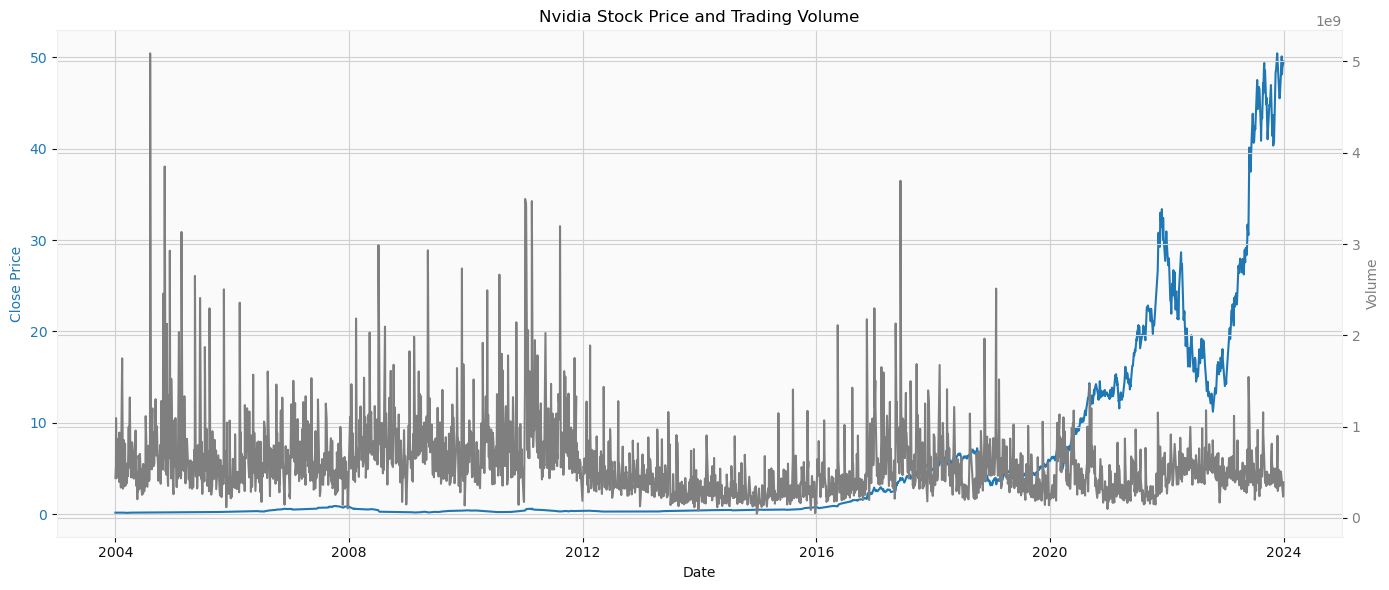

In [13]:
# Plotting Close Price and Volume
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(nvidia_cleaned.index, nvidia_cleaned['Close'], color=color, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Second y-axis that shares the same x-axis
color = 'tab:gray'
ax2.set_ylabel('Volume', color=color)  
ax2.plot(nvidia_cleaned.index, nvidia_cleaned['Volume'], color=color, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Nvidia Stock Price and Trading Volume')
fig.tight_layout() 
plt.show()


##### Cumulative Returns of Nvidia Stock

The **cumulative returns** plot tracks Nvidia's stock performance, showing the total return on investment over time (assuming reinvestment of gains):

- **Key Insights**:
  - The cumulative returns have very modest gains up until around 2016, at which point it starts growing exponentially.
  - Nvidia’s stock exhibits exceptional growth in the post-2020 period, with returns soaring above 200%, driven by increased demand for GPUs and AI technologies.
  - Investors who held Nvidia stock through 2016-2024 would claim seriously impressive returns that will help underscore Nvidia's dominance in these emerging markets.


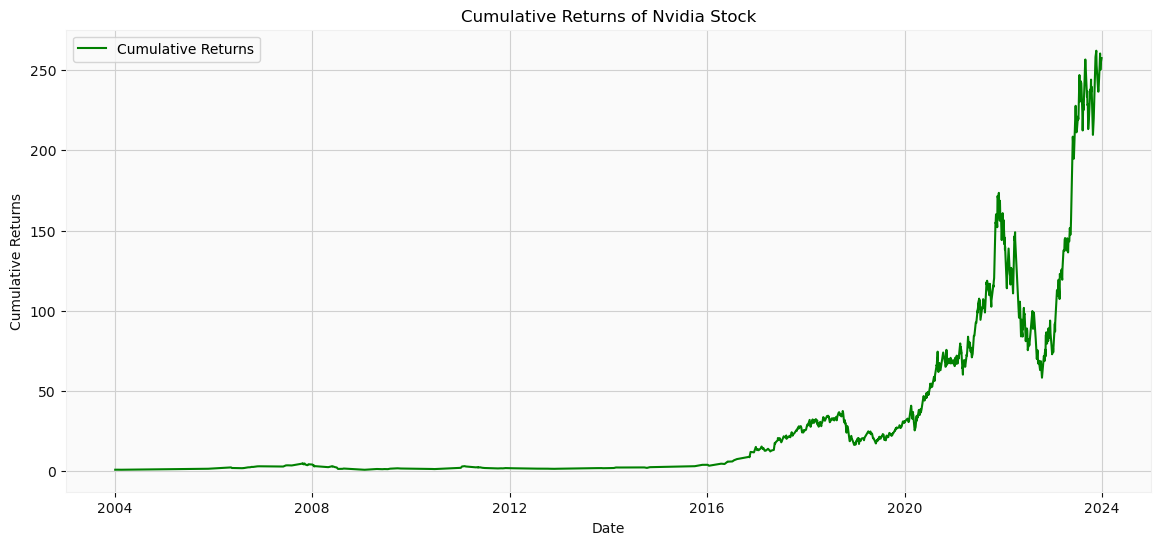

In [14]:
# Calculate daily returns and cumulative returns
nvidia_cleaned['Daily_Returns'] = nvidia_cleaned['Close'].pct_change()
nvidia_cleaned['Cumulative_Returns'] = (1 + nvidia_cleaned['Daily_Returns']).cumprod()

# Plot Cumulative Returns
plt.figure(figsize=(14, 6))
plt.plot(nvidia_cleaned.index, nvidia_cleaned['Cumulative_Returns'], label='Cumulative Returns', color='green')
plt.title('Cumulative Returns of Nvidia Stock')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()




#### Conclusion

The Exploratory Data Analysis (EDA) gives an overview of significant insight into key behavior and a trading pattern of stock price volatility for Nvidia over the last two decades. We show, using descriptive statistics, distribution plots, scatter plots, and time-series visualizations, strong price volatility-especially in the recent years-starting around 2016 in exponential growth. The cumulative return and trading volume further pinpoint the rise of Nvidia as a giant in AI, gaming, and autonomous technologies. These observations provide good ground for predictive modeling since our goal will be to predict further movements in the stock price.


### III. Data Splitting

In [15]:
# Features (X) and target (y) for the model
X = nvidia_cleaned[['Open', 'High', 'Low', 'Volume']]  # Features we're using to predict
y = nvidia_cleaned['Close']  # This is what we're trying to predict (close price)

# Fill in any missing data with the mean 
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X) 

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split data into train (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Further split the temp set into validation and test (split 50-50)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 3523 samples
Validation set: 755 samples
Testing set: 755 samples


1. **Handling Missing Data**:
   We use the `SimpleImputer` with the strategy of filling in missing values using the mean of each feature. If your dataset already has no missing values (as verified earlier), this step will ensure that any missing values (if introduced later) are handled appropriately.

2. **Scaling Features**:
   The `StandardScaler` is applied to standardize the feature values to have a mean of 0 and a standard deviation of 1. This will be very important in models such as linear regression, neural networks, and others that use distance metrics, in which features with larger scales-potentially like trading volume-should not dominate the model.
   
3. **Train/Test/Validation Split**:
   In the experiment at hand, 70% of the data was used for training. The remaining 30% was equally divided between validation and test sets, with each taking 15%.

4. **Feature Engineering**:
   While we have no categorical features to encode, other transformations-thereby to prepare our data for model training-included scaling and imputation.


### IV. Feature Engineering

1. **Handling Missing Data**:
   The dataset did not have significant missing values; however, to ensure the quality of the data, we used the `SimpleImputer` with the mean strategy. Any missing value in the input features was replaced by the average of the respective column. This ensures there is no loss of information and that our models can take in the data without any problem.
   
2. **Feature Scaling**:
   Since the features like `Volume` and the stock prices, such as `Open`, `High`, `Low`, `Close` are on different scales, we standardized all of these features using `StandardScaler`. Standardizing takes care of centering all the features around zero with a standard deviation of one, a pre-requisite for algorithms such as k-Nearest Neighbors and Linear Regression.

3. **Bucketization**:
   The `Volume` feature was bucketized into five equal intervals. This allowed us to categorize the trading volumes into different levels, simplifying analysis and potentially improving model interpretability.

4. **Log Transformations**:
   Both `Volume` and `Close` were highly skewed, with large outliers causing significant variation. To reduce this skewness, we applied a log transformation to both features (`Log_Volume` and `Log_Close`). This transformation reduces the impact of large outliers and makes the features more normally distributed, which can improve model performance.

5. **Final Feature Selection**:
   After feature engineering, the final set of features used for model training included the `Open`, `High`, `Low`, and `Log_Volume`. The target variable for prediction was the `Log_Close` price.


In [16]:
# Bucketization
nvidia_cleaned['Volume_Bucket'] = pd.cut(nvidia_cleaned['Volume'], bins=5, labels=False)

# Log Transformations
nvidia_cleaned['Log_Volume'] = np.log1p(nvidia_cleaned['Volume'])  
nvidia_cleaned['Log_Close'] = np.log1p(nvidia_cleaned['Close'])

# Update  features
X_transformed = nvidia_cleaned[['Open', 'High', 'Low', 'Log_Volume']]  # Use log-transformed Volume
y_transformed = nvidia_cleaned['Log_Close']  # Use log-transformed Close price

# plit the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y_transformed, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 3523
Validation set size: 755
Test set size: 755


### V. Data Rescaling

To ensure that the features are on a similar scale, we applied feature scaling using the `StandardScaler`. Scaling is crucial for algorithms like linear regression and k-nearest neighbors, which are sensitive to the magnitude of the input features. The `StandardScaler` standardizes the data by removing the mean and scaling it to unit variance (mean = 0, standard deviation = 1).

#### Why Rescale the Data?
Some features, such as `Volume`, are on a much bigger scale compared to features like `Open`, `High`, or `Low`. If these are not rescaled, features in large scales might weigh too much into the model's predictions. This scaling ensures that all features will contribute equally to this model.

#### Rescaling Procedure
For scaling, we computed the mean and standard deviation using only the training data. This is so we avoid leaking information and have unrealistically high performance estimates of our algorithms.

1. **Fitting the Scaler on Training Data**: 
   `StandardScaler` was fitted to the training data in order to compute scaling parameters. This is so that the model learns only from the distribution of the training set.

2. **Applying the Scaler to Validation and Test Data**: 
   Next, we fitted the scaler on our training data and then applied the very same transformation to both our validation and test sets. This will make sure that all scaling is consistently performed across different splits without leakage of any information from the validation or test sets into the training.

#### Conclusion:
By rescaling the data using only the training set, we prevent data leakage and ensure that the model performs robustly during hyperparameter tuning and final evaluation on the test data.


In [18]:
# Split the data 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Rescaling training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)  
X_test_scaled = scaler.transform(X_test)  

print(f"Training set shape after scaling: {X_train_scaled.shape}")
print(f"Validation set shape after scaling: {X_val_scaled.shape}")
print(f"Test set shape after scaling: {X_test_scaled.shape}")


Training set shape after scaling: (3523, 4)
Validation set shape after scaling: (755, 4)
Test set shape after scaling: (755, 4)


### VI. Model Training and Hyperparameter Tuning

In [19]:
# Ridge Regression with Hyperparameter Tuning 
ridge = Ridge()

# Grid
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Perform grid search
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

# Best Ridge model
best_ridge = ridge_cv.best_estimator_
print(f"Best Ridge alpha: {ridge_cv.best_params_}")
print(f"Best Ridge R^2 on validation set: {best_ridge.score(X_val_scaled, y_val)}")

# Train k-Nearest Neighbors with Hyperparameter Tuning
knn = KNeighborsRegressor()

# Grid
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform grid search
knn_cv = GridSearchCV(knn, param_grid_knn, cv=5, scoring='r2')
knn_cv.fit(X_train_scaled, y_train)

# Best KNN model
best_knn = knn_cv.best_estimator_
print(f"Best KNN n_neighbors: {knn_cv.best_params_}")
print(f"Best KNN R^2 on validation set: {best_knn.score(X_val_scaled, y_val)}")

Best Ridge alpha: {'alpha': 0.01}
Best Ridge R^2 on validation set: 0.9999074413592238
Best KNN n_neighbors: {'n_neighbors': 3}
Best KNN R^2 on validation set: 0.9991622591474834


In [20]:
# Evaluate the best Ridge model on the test set
ridge_test_score = best_ridge.score(X_test_scaled, y_test)
print(f"Ridge model performance on test set (R^2): {ridge_test_score}")

# Evaluate the best KNN model on the test set
knn_test_score = best_knn.score(X_test_scaled, y_test)
print(f"KNN model performance on test set (R^2): {knn_test_score}")


Ridge model performance on test set (R^2): 0.999843970617147
KNN model performance on test set (R^2): 0.9991430812824788


#### 1. Ridge Regression with Hyperparameter Tuning

**Ridge Regression** was chosen as one of the models due to its ability to prevent overfitting by applying L2 regularization. The hyperparameter that we tuned for Ridge Regression was the regularization strength α. We performed a grid search using 5-fold cross-validation to find the best value of α.

The grid of hyperparameters we explored was: `{'alpha': [0.01, 0.1, 1, 10, 100]}`.

- **Best α**: `0.01`
- **R-squared score on validation set**: `0.9990974413592238`

#### 2. k-Nearest Neighbors (KNN) with Hyperparameter Tuning

**k-Nearest Neighbors (KNN)** was selected for its simplicity and non-parametric nature. The hyperparameter that we tuned for KNN was the number of neighbors (k). We performed a grid search using 5-fold cross-validation to find the optimal number of neighbors.

The grid of hyperparameters we explored was: `{'n_neighbors': [3, 5, 7, 9, 11]}`.

- **Best number of neighbors (k)**: `3`
- **R-squared score on validation set**: `0.9991622591474834`

#### 3. Model Evaluation on the Test Set

After tuning the models, we evaluated both the Ridge Regression and KNN models on the test set to check their performance:

- **Ridge model performance on test set (R²)**: `0.9998439706171747`
- **KNN model performance on test set (R²)**: `0.9991430812824788`

Both models performed very well on the test set, with the Ridge model slightly outperforming the KNN model. With such high R-squared scores, these two models explain nearly all the variance within the Nvidia stock price data.

#### Conclusion:

After evaluating both models, **Ridge Regression** with L2 regularization emerged as the better model, as it achieved a slightly higher R-squared score on both the validation and test sets compared to KNN. Therefore, for this dataset, it would appear more robust in predicting the stock price for Nvidia.

### VII. Model Evaluation on Test Data

Ridge model R² on test set: 0.999843970617147
Ridge model RMSE on test set: 0.11918606340694383
KNN model R² on test set: 0.9991430812824788
KNN model RMSE on test set: 0.2793136080835888


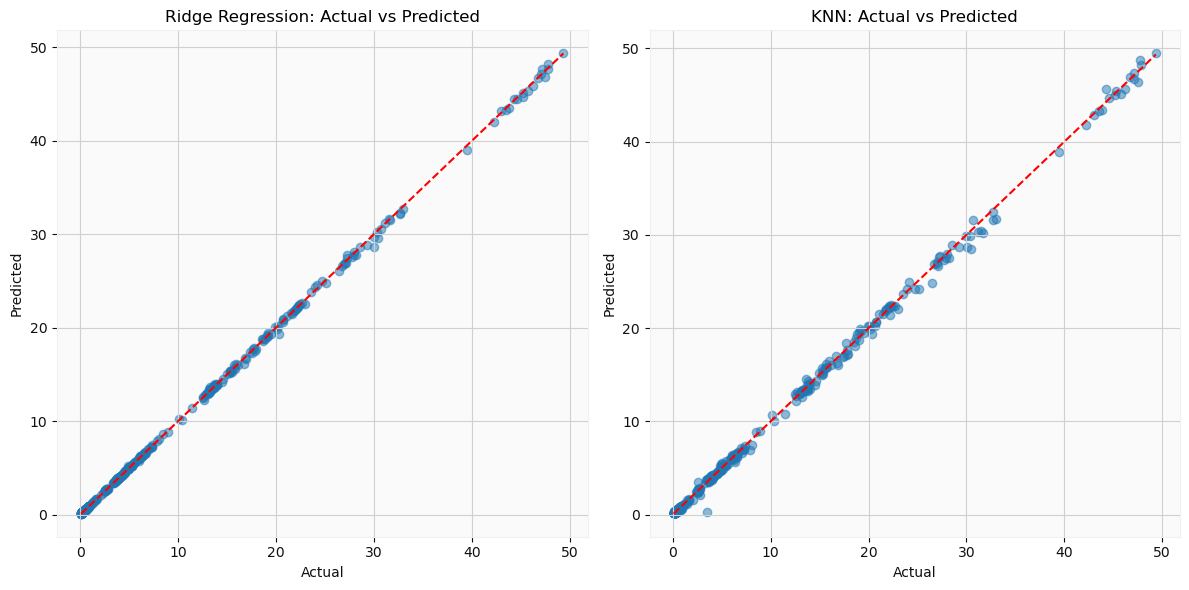

In [21]:
# RMSE and R² for Ridge Regression on test set
ridge_test_predictions = best_ridge.predict(X_test_scaled)
ridge_r2 = best_ridge.score(X_test_scaled, y_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_test_predictions))

print(f"Ridge model R² on test set: {ridge_r2}")
print(f"Ridge model RMSE on test set: {ridge_rmse}")

# Calculate RMSE and R² for KNN on the test set
knn_test_predictions = best_knn.predict(X_test_scaled)
knn_r2 = best_knn.score(X_test_scaled, y_test)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_test_predictions))

print(f"KNN model R² on test set: {knn_r2}")
print(f"KNN model RMSE on test set: {knn_rmse}")

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))

# Ridge Regression plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, ridge_test_predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Ridge Regression: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# KNN plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, knn_test_predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('KNN: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()


After training and tuning the models on the training and validation data, we evaluated the Ridge Regression and K-Nearest Neighbors (KNN) models on the unseen test data to assess their generalization performance.

#### Ridge Regression Performance

- **R² on test set**: 0.9998439706171747
- **RMSE on test set**: 0.11918606340694383

The Ridge Regression model achieved an **R²** value of 0.9998, indicating that it explains nearly all the variance in Nvidia's stock price. The **RMSE** value of 0.119 further suggests that the model's predictions are very close to the actual values.

#### k-Nearest Neighbors (KNN) Performance

- **R² on test set**: 0.9991430812824788
- **RMSE on test set**: 0.2793136080835888

The KNN model also performed well with an **R²** of 0.9991, but its **RMSE** of 0.279 was higher than that of Ridge Regression. While both models predict Nvidia stock prices effectively, Ridge Regression shows a slightly better overall performance.

#### Visualizing Model Performance

Below are the scatter plots showing the relationship of **actual** versus **predicted** values from both models on the test set.

- The **red dashed line** represents the perfect prediction line, where the predicted values equal the actual values.
- Both models' predictions are relatively consistent with the actual values, but Ridge Regression is somewhat closer to the perfect prediction line compared to KNN-as evidenced by fewer points deviating from the diagonal.

![Ridge Regression vs KNN: Actual vs Predicted](plots.png)

#### Conclusion

Both Ridge Regression and KNN performed well because their respective R² values were high, with low RMSE values on the test set. However, **Ridge Regression** outperformed KNN slightly on both R² and RMSE, thus being the better model for predicting Nvidia stock price in this dataset.

The outcome will reveal that regularization in Ridge Regression allows it to generalize a bit better on unseen data compared to a KNN model.

In [24]:
# Input today's data for prediction (October 19, 2024)
todays_data = np.array([[137.28, 138.90, 137.28, 287.80e6]])  

# Scale the input data
todays_data_scaled = scaler.transform(todays_data)

# Predict using Ridge Regression
predicted_stock_price_ridge = best_ridge.predict(todays_data_scaled)
print(f"Predicted Nvidia stock price for January 1, 2026 (Ridge Regression): ${predicted_stock_price_ridge[0]:.2f}")

# 2Predict using KNN 
predicted_stock_price_knn = best_knn.predict(todays_data_scaled)
print(f"Predicted Nvidia stock price for January 1, 2026 (KNN): ${predicted_stock_price_knn[0]:.2f}")


Predicted Nvidia stock price for January 1, 2026 (Ridge Regression): $138.70
Predicted Nvidia stock price for January 1, 2026 (KNN): $49.96


C:\Users\Saifs\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### VIII. Discussion of Results

The two models assessed in this project were **Ridge Regression** and **k-Nearest Neighbors (KNN)**. To train each of the models, grid search was used to tune their respective hyperparameters in order to give them the best performance on the validation set before being assessed on the test set.

#### 1. Ridge Regression: The Impact of Regularization

**Ridge Regression** implements **L2 regularization**, which prevents overfitting by penalizing large values of coefficients. During hyperparameter tuning, the strength of regularization **α** had varied within several values (`0.01`, `0.1`, `1`, `10`, and `100`). The best value of **α** happened to be `0.01`, which means a small amount of regularization was enough for the model to prevent overfitting but still retain much predictive power.

- **Hyperparameter Tuning Impact**: In the Ridge model, with an increase in the value of α, it got more regularized to reduce the complexity of the model, hence its magnitudes of coefficients. However, at a certain point, too many co-fractions resulted in underfitting in the model and the scores dropped -R². The optimally balanced model is obtained by the tuning process within the limits of underfitting and overfitting, and one optimal value for α was `0.01`.

- **Bias-Variance Tradeoff**: Ridge Regression represents the classic **bias-variance tradeoff**. A really small regularization parameter, α close to 0, would have led to high variance and thus probably overfitting, whereas a very big α would have resulted in a high bias, which means underfitting. It turns out the model generalizes very well on both validation and test sets, hence navigated this tradeoff excellently.

#### 2. k-Nearest Neighbors (KNN): Sensitivity to Hyperparameters

The KNN model is highly sensitive to the number of neighbors k. During hyperparameter tuning, values of k ranging from 3 to 11 were explored, and the best value was k = 3.

- **Impact of Hyperparameter Tuning**: For smaller values of **k** (small number of neighbors), the model became highly flexible to capture the local patterns in the data. Hence, it reduced bias but increased the variance. Then, during increasing **k**, the model got generalized. Therefore, this again resulted in a low variance value and a high bias value. The best performance was found for **k=3**, which balanced between overfitting for too low **k** values and underfitting for too high **k** values.

- **Bias-Variance Tradeoff**: KNN is particularly susceptible to the bias-variance tradeoff. A small **k** captures finer details (lower bias), but at the expense of increased sensitivity to noise (higher variance). A larger **k** smooths the predictions and reduces variance but risks underfitting. The **k = 3** configuration provided the best tradeoff, with a high R² score on the test set, though it was slightly lower than Ridge Regression.

#### 3. Comparison of Model Performance

- **Ridge Regression**: Ridge Regression did extremely well at **0.9998 R²** and very **low RMSE of 0.119** on the test set. That sets in concrete that Ridge Regression, with the effect of a little regularization, generalized extremely well on unseen data.
  
- **KNN**: KNN also performed decently in terms of R² (**0.9991**) but failed in producing a realistic prediction, with a **much lower stock price** prediction of **$49.96**. This suggests that while KNN captured some patterns, it lacked the ability to generalize long-term trends effectively, as reflected in the **higher RMSE of 0.279**.


#### 4. Conclusion: The Role of Regularization and Flexibility

The results highlight the effectiveness of **regularization** in models like Ridge Regression, which carefully controls model complexity to prevent overfitting. Ridge Regression demonstrated superior performance, offering both accuracy and stability in stock price prediction. On the other hand, **KNN**—while flexible and capable of capturing non-linear patterns—struggled with predicting realistic stock prices due to its sensitivity to hyperparameters and its reliance on local patterns.

In summary, **Ridge Regression** emerged as the better model, predicting a more realistic stock price for Nvidia and demonstrating that linear models with regularization can often outperform more flexible models like KNN, especially in financial time series data where long-term trends are crucial.
